# Exploring the neighborhoods of Manhattan, New York and Toronto, Canada

## Applying data wrangling on Manhattan Dataset and then clustering using k-Means

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
! pip install requests
! pip install html5lib
! pip install bs4

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import matplotlib.pyplot as plt
print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

The files are downloaded and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [8]:
neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Then let's loop through the data and fill the dataframe one row at a time.

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [10]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Create a map of New York with neighborhoods superimposed on top.

In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [14]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

Let's get the geographical coordinates of Manhattan.

In [15]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [16]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'HPPNIJVXOZNEQNVAXEZ0DMOID0RY3QWDRGISE03M2GQ3OE0D' # your Foursquare ID
CLIENT_SECRET = 'DXZVUECBAG4V1S2W5SW0OD2YAJBMN1W3D4DQIDYSKX2JTB2H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HPPNIJVXOZNEQNVAXEZ0DMOID0RY3QWDRGISE03M2GQ3OE0D
CLIENT_SECRET:DXZVUECBAG4V1S2W5SW0OD2YAJBMN1W3D4DQIDYSKX2JTB2H


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [18]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [19]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [20]:
# type your answer here
radius = 500
limit = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, limit)
url

'https://api.foursquare.com/v2/venues/explore?client_id=HPPNIJVXOZNEQNVAXEZ0DMOID0RY3QWDRGISE03M2GQ3OE0D&client_secret=DXZVUECBAG4V1S2W5SW0OD2YAJBMN1W3D4DQIDYSKX2JTB2H&ll=40.87655077879964,-73.91065965862981&v=20180605&radius=500&limit=100'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c8e6f3e6a607168d072b30c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name          categories        lat        lng
0               Arturo's         Pizza Place  40.874412 -73.910271
1            Bikram Yoga         Yoga Studio  40.876844 -73.906204
2          Tibbett Diner               Diner  40.880404 -73.908937
3              Starbucks         Coffee Shop  40.877531 -73.905582
4  Land & Sea Restaurant  Seafood Restaurant  40.877885 -73.905873

And how many venues were returned by Foursquare?

In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


<a id='item2'></a>

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [25]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [26]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [27]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3302, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876551               -73.91066   
1  Marble Hill              40.876551               -73.91066   
2  Marble Hill              40.876551               -73.91066   
3  Marble Hill              40.876551               -73.91066   
4  Marble Hill              40.876551               -73.91066   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  
0               Arturo's       40.874412       -73.910271         Pizza Place  
1            Bikram Yoga       40.876844       -73.906204         Yoga Studio  
2          Tibbett Diner       40.880404       -73.908937               Diner  
3              Starbucks       40.877531       -73.905582         Coffee Shop  
4  Land & Sea Restaurant       40.877885       -73.905873  Seafood Restaurant

Let's check how many venues were returned for each neighborhood

In [28]:
manhattan_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Battery Park City                       99                      99     99   
Carnegie Hill                          100                     100    100   
Central Harlem                          44                      44     44   
Chelsea                                100                     100    100   
Chinatown                              100                     100    100   
Civic Center                           100                     100    100   
Clinton                                100                     100    100   
East Harlem                             41                      41     41   
East Village                           100                     100    100   
Financial District                     100                     100    100   
Flatiron                               100                     100    100   
Gramercy                               100                     100    100   
Greenwich Village                      100                     100    100   
Hamilton Heights                        60                      60     60   
Hudson Yards                            61                      61     61   
Inwood                                  56                      56     56   
Lenox Hill                             100                     100    100   
Lincoln Square                         100                     100    100   
Little Italy                           100                     100    100   
Lower East Side                         60                      60     60   
Manhattan Valley                        58                      58     58   
Manhattanville                          40                      40     40   
Marble Hill                             24                      24     24   
Midtown                                100                     100    100   
Midtown South                          100                     100    100   
Morningside Heights                     43                      43     43   
Murray Hill                            100                     100    100   
Noho                                   100                     100    100   
Roosevelt Island                        26                      26     26   
Soho                                   100                     100    100   
Stuyvesant Town                         18                      18     18   
Sutton Place                           100                     100    100   
Tribeca                                100                     100    100   
Tudor City                              84                      84     84   
Turtle Bay                             100                     100    100   
Upper East Side                        100                     100    100   
Upper West Side                        100                     100    100   
Washington Heights                      88                      88     88   
West Village                           100                     100    100   
Yorkville                              100                     100    100   

                     Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                          
Battery Park City                99               99              99  
Carnegie Hill                   100              100             100  
Central Harlem                   44               44              44  
Chelsea                         100              100             100  
Chinatown                       100              100             100  
Civic Center                    100              100             100  
Clinton                         100              100             100  
East Harlem                      41               41              41  
East Village                    100              100             100  
Finan

#### Let's find out how many unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 329 uniques categories.


<a id='item3'></a>

In [30]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0  Marble Hill                  0               0                  0   
1  Marble Hill                  0               0                  0   
2  Marble Hill                  0               0                  0   
3  Marble Hill                  0               0                  0   
4  Marble Hill                  0               0                  0   

   African Restaurant  American Restaurant  Animal Shelter  Antique Shop  \
0                   0                    0               0             0   
1                   0                    0               0             0   
2                   0                    0               0             0   
3                   0                    0               0             0   
4                   0                    0               0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   0           0   
1                    0                 0                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   0           0   
4                    0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  Auto Workshop  BBQ Joint  \
0                      0                    0              0          0   
1                      0                    0              0          0   
2                      0                    0              0          0   
3                      0                    0              0          0   
4                      0                    0              0          0   

   Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0           0           0       0     0    0               0   
1           0           0       0     0    0               0   
2           0           0       0     0    0               0   
3           0           0       0     0    0               0   
4           0           0       0     0    0               0   

   Basketball Court  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0                 0                0         0            0           0   
1                 0                0         0            0           0   
2                 0                0         0            0           0   
3                 0                0         0            0           0   
4                 0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Boxing Gym  \
0           0              0          0         0           0   
1           0              0          0         0           0   
2           0              0          0         0           0   
3           0              0          0         0           0   
4           0              0          0         0           0   

   Brazilian Restaurant  Breakfas

And let's examine the new dataframe size.

In [31]:
manhattan_onehot.shape

(3302, 330)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0     Battery Park City           0.000000            0.00               0.00   
1         Carnegie Hill           0.000000            0.00               0.00   
2        Central Harlem           0.000000            0.00               0.00   
3               Chelsea           0.000000            0.00               0.00   
4             Chinatown           0.000000            0.00               0.00   
5          Civic Center           0.000000            0.00               0.00   
6               Clinton           0.000000            0.00               0.00   
7           East Harlem           0.000000            0.00               0.00   
8          East Village           0.000000            0.00               0.00   
9    Financial District           0.010000            0.00               0.00   
10             Flatiron           0.000000            0.00               0.00   
11             Gramercy           0.000000            0.00               0.00   
12    Greenwich Village           0.000000            0.00               0.00   
13     Hamilton Heights           0.000000            0.00               0.00   
14         Hudson Yards           0.000000            0.00               0.00   
15               Inwood           0.000000            0.00               0.00   
16           Lenox Hill           0.000000            0.00               0.01   
17       Lincoln Square           0.000000            0.00               0.00   
18         Little Italy           0.000000            0.00               0.00   
19      Lower East Side           0.000000            0.00               0.00   
20     Manhattan Valley           0.000000            0.00               0.00   
21       Manhattanville           0.000000            0.00               0.00   
22          Marble Hill           0.000000            0.00               0.00   
23              Midtown           0.000000            0.00               0.00   
24        Midtown South           0.000000            0.00               0.00   
25  Morningside Heights           0.000000            0.00               0.00   
26          Murray Hill           0.000000            0.00               0.00   
27                 Noho           0.000000            0.01               0.00   
28     Roosevelt Island           0.000000            0.00               0.00   
29                 Soho           0.000000            0.00               0.00   
30      Stuyvesant Town           0.000000            0.00               0.00   
31         Sutton Place           0.000000            0.01               0.00   
32              Tribeca           0.000000            0.00               0.00   
33           Tudor City           0.000000            0.00               0.00   
34           Turtle Bay           0.000000            0.00               0.00   
35      Upper East Side           0.000000            0.00               0.00   
36      Upper West Side           0.010000            0.00               0.00   
37   Washington Heights           0.011364            0.00               0.00   
38         West Village           0.010000            0.00               0.00   
39            Yorkville           0.000000            0.00               0.00   

    African Restaurant  American Restaurant  Animal Shelter  Antique Shop  \
0             0.000000             0.010101            0.00          0.00   
1             0.000000             0.010000            0.00          0.00   
2             0.068182             0.045455            0.00          0.00   
3             0.000000             0.040000            0.00          0.00   
4             0.000000             0.040000            0.00          0.00   
5             0.000000             0.030000            0.00          0.01   
6             0.000000             0.040000            0.00          0.00   
7             0.000000             0.000000            0.00          0.00

#### Let's confirm the new size

In [33]:
manhattan_grouped.shape

(40, 330)

#### Let's print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
         venue  freq
0  Coffee Shop  0.08
1         Park  0.08
2        Hotel  0.05
3          Gym  0.03
4    Wine Shop  0.03


----Carnegie Hill----
                 venue  freq
0          Pizza Place  0.06
1          Coffee Shop  0.06
2                  Bar  0.04
3                 Café  0.04
4  Japanese Restaurant  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1  American Restaurant  0.05
2           Public Art  0.05
3   Seafood Restaurant  0.05
4    French Restaurant  0.05


----Chelsea----
                 venue  freq
0          Coffee Shop  0.07
1   Italian Restaurant  0.06
2       Ice Cream Shop  0.05
3            Nightclub  0.04
4  American Restaurant  0.04


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1    American Restaurant  0.04
2     Dim Sum Restaurant  0.04
3           Cocktail Bar  0.04
4  Vietnamese Restaurant  0.04


----Civic Center----
                  venue  freq


#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Battery Park City                  Park           Coffee Shop   
1      Carnegie Hill           Coffee Shop           Pizza Place   
2     Central Harlem    African Restaurant   American Restaurant   
3            Chelsea           Coffee Shop    Italian Restaurant   
4          Chinatown    Chinese Restaurant   American Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Hotel                   Gym             Wine Shop   
1                    Bar                  Café           Yoga Studio   
2             Public Art  Gym / Fitness Center     French Restaurant   
3         Ice Cream Shop                Bakery   American Restaurant   
4  Vietnamese Restaurant          Cocktail Bar    Dim Sum Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Shopping Mall    Italian Restaurant            Food Court   
1                   Spa             Bookstore        Cosmetics Shop   
2    Chinese Restaurant    Seafood Restaurant          Cycle Studio   
3             Nightclub                 Hotel               Theater   
4          Noodle House    Salon / Barbershop                Bakery   

  9th Most Common Venue 10th Most Common Venue  
0          Burger Joint               Fountain  
1     French Restaurant                    Gym  
2             Bookstore   Ethiopian Restaurant  
3    Seafood Restaurant       Asian Restaurant  
4     Hotpot Restaurant         Ice Cream Shop

<a id='item4'></a>

Run *k*-means to cluster the neighborhood into 5 clusters.

In [37]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 2, 0, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Manhattan         Marble Hill  40.876551 -73.910660               1   
1  Manhattan           Chinatown  40.715618 -73.994279               1   
2  Manhattan  Washington Heights  40.851903 -73.936900               1   
3  Manhattan              Inwood  40.867684 -73.921210               0   
4  Manhattan    Hamilton Heights  40.823604 -73.949688               0   

  1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
0        Discount Store           Coffee Shop            Yoga Studio   
1    Chinese Restaurant   American Restaurant  Vietnamese Restaurant   
2                  Café                Bakery      Mobile Phone Shop   
3    Mexican Restaurant                  Café          Deli / Bodega   
4    Mexican Restaurant           Coffee Shop                   Café   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Clothing Store        Tennis Stadium         Big Box Store   
1          Cocktail Bar    Dim Sum Restaurant          Noodle House   
2         Deli / Bodega  Gym / Fitness Center           Supermarket   
3                Lounge           Pizza Place            Restaurant   
4           Pizza Place         Deli / Bodega          Liquor Store   

  7th Most Common Venue      8th Most Common Venue 9th Most Common Venue  \
0       Supplement Shop                        Spa            Shoe Store   
1    Salon / Barbershop                     Bakery     Hotpot Restaurant   
2    Spanish Restaurant  Latin American Restaurant    Mexican Restaurant   
3    Chinese Restaurant         Frozen Yogurt Shop           Coffee Shop   
4     Indian Restaurant           Sushi Restaurant        Sandwich Place   

  10th Most Common Venue  
0     Seafood Restaurant  
1         Ice Cream Shop  
2       Tapas Restaurant  
3                 Bakery  
4            Yoga Studio

Finally, let's visualize the resulting clusters

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [40]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
3             Inwood    Mexican Restaurant                  Café   
4   Hamilton Heights    Mexican Restaurant           Coffee Shop   
7        East Harlem    Mexican Restaurant                Bakery   
25  Manhattan Valley     Indian Restaurant           Pizza Place   
36        Tudor City    Mexican Restaurant                  Park   

   3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
3          Deli / Bodega                     Lounge           Pizza Place   
4                   Café                Pizza Place         Deli / Bodega   
7          Deli / Bodega  Latin American Restaurant       Thai Restaurant   
25           Coffee Shop                Yoga Studio                   Bar   
36                  Café                    Dog Run           Pizza Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3             Restaurant    Chinese Restaurant    Frozen Yogurt Shop   
4           Liquor Store     Indian Restaurant      Sushi Restaurant   
7              Pet Store     Convenience Store          Dance Studio   
25     French Restaurant    Mexican Restaurant                  Café   
36                 Hotel      Asian Restaurant      Sushi Restaurant   

   9th Most Common Venue 10th Most Common Venue  
3            Coffee Shop                 Bakery  
4         Sandwich Place            Yoga Studio  
7               Beer Bar            Pizza Place  
25       Thai Restaurant    Hawaiian Restaurant  
36      Greek Restaurant          Deli / Bodega

#### Cluster 2

In [41]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
0           Marble Hill        Discount Store              Coffee Shop   
1             Chinatown    Chinese Restaurant      American Restaurant   
2    Washington Heights                  Café                   Bakery   
5        Manhattanville    Seafood Restaurant       Mexican Restaurant   
6        Central Harlem    African Restaurant      American Restaurant   
8       Upper East Side    Italian Restaurant              Coffee Shop   
9             Yorkville    Italian Restaurant              Coffee Shop   
10           Lenox Hill    Italian Restaurant         Sushi Restaurant   
12      Upper West Side    Italian Restaurant                      Bar   
15              Midtown        Clothing Store                    Hotel   
16          Murray Hill           Coffee Shop                    Hotel   
17              Chelsea           Coffee Shop       Italian Restaurant   
18    Greenwich Village    Italian Restaurant           Clothing Store   
19         East Village                   Bar                 Wine Bar   
20      Lower East Side    Chinese Restaurant         Ramen Restaurant   
21              Tribeca    Italian Restaurant                     Park   
22         Little Italy                Bakery                     Café   
23                 Soho        Clothing Store                 Boutique   
24         West Village    Italian Restaurant  New American Restaurant   
26  Morningside Heights           Coffee Shop                Bookstore   
27             Gramercy          Cocktail Bar   Thrift / Vintage Store   
28    Battery Park City                  Park              Coffee Shop   
29   Financial District           Coffee Shop                    Hotel   
30        Carnegie Hill           Coffee Shop              Pizza Place   
31                 Noho    Italian Restaurant        French Restaurant   
32         Civic Center  Gym / Fitness Center                   Bakery   
33        Midtown South     Korean Restaurant                Hotel Bar   
34         Sutton Place  Gym / Fitness Center   Furniture / Home Store   
35           Turtle Bay    Italian Restaurant         Sushi Restaurant   
38             Flatiron           Yoga Studio      American Restaurant   

            3rd Most Common Venue 4th Most Common Venue  \
0                     Yoga Studio        Clothing Store   
1           Vietnamese Restaurant          Cocktail Bar   
2               Mobile Phone Shop         Deli / Bodega   
5                            Park    Italian Restaurant   
6                      Public Art  Gym / Fitness Center   
8                         Exhibit           Art Gallery   
9                             Gym                   Bar   
10                    Coffee Shop  Gym / Fitness Center   
12  Vegetarian / Vegan Restaurant     Indian Restaurant   
15                   Cocktail Bar            Steakhouse   
16                            Spa     French Restaurant   
17                 Ice Cream Shop                Bakery   
18              French Restaurant      Sushi Restaurant   
19                 Ice Cream Shop    Mexican Restaurant   
20                    Art Gallery           Coffee Shop   
21                           Café                   Spa   
22             Seafood Restaurant        Sandwich Place   
23                  Women's Store            Shoe Store   
24                      Gastropub        Cosmetics Shop   
26                     Food Truck                  Park   
27                    Coffee Shop    Italian Restaurant   
28                          Hotel                   Gym   
29                     Steakhouse    Italian Restaurant   
30                            Bar                  Café   
31                   Cocktail Bar           Coffee Shop   
32              French Restaurant    Italian Restaurant   
33                          Hotel   Japanese Restaurant   
34              Indian Restaurant    Italian Restaurant   
35   

#### Cluster 3

In [42]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
13  Lincoln Square  Gym / Fitness Center               Theater   
14         Clinton               Theater   American Restaurant   
39    Hudson Yards    Italian Restaurant           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
13                  Café                 Plaza          Concert Hall   
14                 Hotel  Gym / Fitness Center         Indie Theater   
39                 Hotel                  Café               Theater   

   6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
13    Italian Restaurant     French Restaurant  Performing Arts Venue   
14             Wine Shop                   Spa            Coffee Shop   
39  Gym / Fitness Center            Restaurant    American Restaurant   

   9th Most Common Venue 10th Most Common Venue  
13                  Park            Opera House  
14                   Gym     Italian Restaurant  
39                  Park                Dog Run

#### Cluster 4

In [43]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
37  Stuyvesant Town                   Bar                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
37           Pet Service        Baseball Field       Harbor / Marina   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
37        Farmers Market           Beer Garden          Cocktail Bar   

   9th Most Common Venue 10th Most Common Venue  
37           Coffee Shop               Heliport

#### Cluster 5

In [44]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
11  Roosevelt Island        Sandwich Place           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
11                  Park   Japanese Restaurant  Outdoors & Recreation   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
11      Greek Restaurant         Metro Station   Monument / Landmark   

   9th Most Common Venue 10th Most Common Venue  
11           Supermarket            Bus Station

In [45]:
manhattan_new = manhattan_merged[['Neighborhood','1st Most Common Venue']].copy()
manhattan_new

Neighborhood 1st Most Common Venue
0           Marble Hill        Discount Store
1             Chinatown    Chinese Restaurant
2    Washington Heights                  Café
3                Inwood    Mexican Restaurant
4      Hamilton Heights    Mexican Restaurant
5        Manhattanville    Seafood Restaurant
6        Central Harlem    African Restaurant
7           East Harlem    Mexican Restaurant
8       Upper East Side    Italian Restaurant
9             Yorkville    Italian Restaurant
10           Lenox Hill    Italian Restaurant
11     Roosevelt Island        Sandwich Place
12      Upper West Side    Italian Restaurant
13       Lincoln Square  Gym / Fitness Center
14              Clinton               Theater
15              Midtown        Clothing Store
16          Murray Hill           Coffee Shop
17              Chelsea           Coffee Shop
18    Greenwich Village    Italian Restaurant
19         East Village                   Bar
20      Lower East Side    Chinese Restaurant
21              Tribeca    Italian Restaurant
22         Little Italy                Bakery
23                 Soho        Clothing Store
24         West Village    Italian Restaurant
25     Manhattan Valley     Indian Restaurant
26  Morningside Heights           Coffee Shop
27             Gramercy          Cocktail Bar
28    Battery Park City                  Park
29   Financial District           Coffee Shop
30        Carnegie Hill           Coffee Shop
31                 Noho    Italian Restaurant
32         Civic Center  Gym / Fitness Center
33        Midtown South     Korean Restaurant
34         Sutton Place  Gym / Fitness Center
35           Turtle Bay    Italian Restaurant
36           Tudor City    Mexican Restaurant
37      Stuyvesant Town                   Bar
38             Flatiron           Yoga Studio
39         Hudson Yards    Italian Restaurant

In [46]:
gp_new = manhattan_new.groupby(['1st Most Common Venue']).count()

In [47]:
gp_new.rename(columns={'Neighborhood':'Count_Common_Venue'}, inplace = True)
gp_new.reset_index()
gp_new

Count_Common_Venue
1st Most Common Venue                    
African Restaurant                      1
Bakery                                  1
Bar                                     2
Café                                    1
Chinese Restaurant                      2
Clothing Store                          2
Cocktail Bar                            1
Coffee Shop                             5
Discount Store                          1
Gym / Fitness Center                    3
Indian Restaurant                       1
Italian Restaurant                     10
Korean Restaurant                       1
Mexican Restaurant                      4
Park                                    1
Sandwich Place                          1
Seafood Restaurant                      1
Theater                                 1
Yoga Studio                             1

In [48]:
manhattan_sorted = gp_new.sort_values(by='Count_Common_Venue', ascending = False)
manhattan_sorted.head(4)

Count_Common_Venue
1st Most Common Venue                    
Italian Restaurant                     10
Coffee Shop                             5
Mexican Restaurant                      4
Gym / Fitness Center                    3

## Now, applying data wrangling on Toronto Dataset and then clustering using k-Means

Scrap wikipedia for the data !!!

In [49]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html5lib')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":876823784,"wgRevisionId":876823784,"wgArticleId":539066,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wg

Create the dataframe with the columns PostalCode, Borough and Neighborhood

In [50]:
column_names = ['PostalCode', 'Borough', 'Neighborhood']
df = pd.DataFrame(columns = column_names)
df

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

Using Nominatim to get latitude and longitude of Toronto

In [51]:
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Scrap the webpage and store the data in a list

In [52]:
my_list = list()
table = soup.findAll('table',attrs={'class':'wikitable sortable'})
for my_table in table:
    table_body = my_table.find('tbody')
    rows = table_body.findAll('tr')
    for r in rows:
        for rw in r.findAll('td'):
            my_list.append(rw.text)

Create seperate lists for the columns and put them in dataframe

In [53]:
list_PostalCode = list()
list_Borough = list()
list_Neighborhood = list()
#Creating a list of all PostalCodes
for code in range(0,len(my_list),3):
    list_PostalCode.append(my_list[code])
#Creating a list of all Boroughs
for borough in range(1,len(my_list),3):
    list_Borough.append(my_list[borough])
#Creating a list of all Neighborhoods 
for neighbor in range(2,len(my_list),3):
    list_Neighborhood.append(my_list[neighbor])
#Removing new line character from Neighborhoods
for neigh in range(len(list_Neighborhood)):
    list_Neighborhood[neigh] = list_Neighborhood[neigh].replace("\n","")

In [54]:
#Populating all the columns to generate the dataframe
df['PostalCode'] = list_PostalCode
df['Borough'] = list_Borough
df['Neighborhood'] = list_Neighborhood
df.head(20)

PostalCode           Borough      Neighborhood
0         M1A      Not assigned      Not assigned
1         M2A      Not assigned      Not assigned
2         M3A        North York         Parkwoods
3         M4A        North York  Victoria Village
4         M5A  Downtown Toronto      Harbourfront
5         M5A  Downtown Toronto       Regent Park
6         M6A        North York  Lawrence Heights
7         M6A        North York    Lawrence Manor
8         M7A      Queen's Park      Not assigned
9         M8A      Not assigned      Not assigned
10        M9A         Etobicoke  Islington Avenue
11        M1B       Scarborough             Rouge
12        M1B       Scarborough           Malvern
13        M2B      Not assigned      Not assigned
14        M3B        North York   Don Mills North
15        M4B         East York  Woodbine Gardens
16        M4B         East York     Parkview Hill
17        M5B  Downtown Toronto           Ryerson
18        M5B  Downtown Toronto   Garden District
19        M6B        North York         Glencairn

Cleaning and merging values in dataset

In [55]:
#Drop rows that do not have Boroughs assigned
df = df[df.Borough != 'Not assigned']
df = df.reset_index(drop=True)
df.head(20)

PostalCode           Borough      Neighborhood
0         M3A        North York         Parkwoods
1         M4A        North York  Victoria Village
2         M5A  Downtown Toronto      Harbourfront
3         M5A  Downtown Toronto       Regent Park
4         M6A        North York  Lawrence Heights
5         M6A        North York    Lawrence Manor
6         M7A      Queen's Park      Not assigned
7         M9A         Etobicoke  Islington Avenue
8         M1B       Scarborough             Rouge
9         M1B       Scarborough           Malvern
10        M3B        North York   Don Mills North
11        M4B         East York  Woodbine Gardens
12        M4B         East York     Parkview Hill
13        M5B  Downtown Toronto           Ryerson
14        M5B  Downtown Toronto   Garden District
15        M6B        North York         Glencairn
16        M9B         Etobicoke        Cloverdale
17        M9B         Etobicoke         Islington
18        M9B         Etobicoke      Martin Grove
19        M9B         Etobicoke  Princess Gardens

In [56]:
#Merge the values of rows having identical PostalCode and Borough and add the names to Neighborhood 
df = df.groupby('PostalCode').agg({ 'Borough': 'first', 
                             'Neighborhood':', '.join }).reset_index()
df.head(20)

PostalCode      Borough                                       Neighborhood
0         M1B  Scarborough                                     Rouge, Malvern
1         M1C  Scarborough             Highland Creek, Rouge Hill, Port Union
2         M1E  Scarborough                  Guildwood, Morningside, West Hill
3         M1G  Scarborough                                             Woburn
4         M1H  Scarborough                                          Cedarbrae
5         M1J  Scarborough                                Scarborough Village
6         M1K  Scarborough        East Birchmount Park, Ionview, Kennedy Park
7         M1L  Scarborough                    Clairlea, Golden Mile, Oakridge
8         M1M  Scarborough    Cliffcrest, Cliffside, Scarborough Village West
9         M1N  Scarborough                        Birch Cliff, Cliffside West
10        M1P  Scarborough  Dorset Park, Scarborough Town Centre, Wexford ...
11        M1R  Scarborough                                  Maryvale, Wexford
12        M1S  Scarborough                                          Agincourt
13        M1T  Scarborough            Clarks Corners, Sullivan, Tam O'Shanter
14        M1V  Scarborough  Agincourt North, L'Amoreaux East, Milliken, St...
15        M1W  Scarborough                      L'Amoreaux West, Steeles West
16        M1X  Scarborough                                        Upper Rouge
17        M2H   North York                                  Hillcrest Village
18        M2J   North York                       Fairview, Henry Farm, Oriole
19        M2K   North York                                    Bayview Village

In [57]:
#Replace the value in Neighborhood with Borough if Neighborhood is Not assigned
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'])
df

PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
16         M1X       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
21         M2M        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North York   
27         M3C        North York   
28         M3H        North York   
29         M3J        North York   
30         M3K        North York   
31         M3L        North York   
32         M3M        North York   
33         M3N        North York   
34         M4A        North York   
35         M4B         East York   
36         M4C         East York   
37         M4E      East Toronto   
38         M4G         East York   
39         M4H         East York   
40         M4J         East York   
41         M4K      East Toronto   
42         M4L      East Toronto   
43         M4M      East Toronto   
44         M4N   Central Toronto   
45         M4P   Central Toronto   
46         M4R   Central Toronto   
47         M4S   Central Toronto   
48         M4T   Central Toronto   
49         M4V   Central Toronto   
50         M4W  Downtown Toronto   
51         M4X  Downtown Toronto   
52         M4Y  Downtown Toronto   
53         M5A  Downtown Toronto   
54         M5B  Downtown Toronto   
55         M5C  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
58         M5H  Downtown Toronto   
59         M5J  Downtown Toronto   
60         M5K  Downtown Toronto   
61         M5L  Downtown Toronto   
62         M5M        North York   
63         M5N   Central Toronto   
64         M5P   Central Toronto   
65         M5R   Central Toronto   
66         M5S  Downtown Toronto   
67         M5T  Downtown Toronto   
68         M5V  Downtown Toronto   
69         M5W  Downtown Toronto   
70         M5X  Downtown Toronto   
71         M6A        North York   
72         M6B        North York   
73         M6C              York   
74         M6E              York   
75         M6G  Downtown Toronto   
76         M6H      West Toronto   
77         M6J      West Toronto   
78         M6K      West Toronto   
79         M6L        North York   
80         M6M              York   
81         M6N              York   
82         M6P      West Toronto   
83         M6R      West Toronto   
84         M6S      West Toronto   
85         M7A      Queen's Park   
86         M7R       Mississauga   
87         M7Y      East Toronto   
88         M8V         Etobicoke   
89         M8W         Etobicoke   
90         M8X         Etobicoke   
91         M8Y         Etobicoke   
92         M8Z         Etobicoke   
93         M9A         Etobicoke   
94         M9B         Etobicoke   
95         M9C         Etobicoke   
96         M9L        North York   
97         M9M        North York   
98         M9N              York   
99         M9P         Etobicoke   
100        M9R         Etobicoke   
101        M9V         Etobicoke   
102        M9W         Etobicoke   

                                          Neighborhood  
0                                       Rouge, Malvern  
1               Highland Creek, Rouge Hill, Port Union  
2                    Guildwood, Morningside, West Hill  
3                              

In [58]:
df.shape

(103, 3)

Assign the latitudes and longitudes to each location by reading the csv file

In [59]:
csv = pd.read_csv('https://cocl.us/Geospatial_data')
csv = csv.rename(columns = {'Postal Code' : 'PostalCode'})
csv.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Create a new dataframe with latitude and longitude for each location

In [60]:
#Perform an inner join on the column 'PostalCode' for both the dataframe
new_df = pd.merge(df, csv, on = ['PostalCode'], how = 'inner')
new_df.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [61]:
new_df.to_csv('example1.csv')

Explore neighborhoods in Toronto

In [62]:
LIMIT = 100
CLIENT_ID = 'HPPNIJVXOZNEQNVAXEZ0DMOID0RY3QWDRGISE03M2GQ3OE0D'
CLIENT_SECRET = 'DXZVUECBAG4V1S2W5SW0OD2YAJBMN1W3D4DQIDYSKX2JTB2H'
VERSION = '20180604'
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Write the code to run the above function on each neighborhood and create a new dataframe called manhattan_venues.

In [63]:
toronto_venues = getNearbyVenues(names=new_df['Neighborhood'],
                                   latitudes=new_df['Latitude'],
                                   longitudes=new_df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The D

In [64]:
print(toronto_venues.shape)
toronto_venues.head()

(2231, 7)


Neighborhood  Neighborhood Latitude  \
0                          Rouge, Malvern              43.806686   
1  Highland Creek, Rouge Hill, Port Union              43.784535   
2  Highland Creek, Rouge Hill, Port Union              43.784535   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                            Venue  Venue Latitude  \
0              -79.194353                          Wendy's       43.807448   
1              -79.160497            Royal Canadian Legion       43.782533   
2              -79.160497   Scarborough Historical Society       43.788755   
3              -79.188711  Swiss Chalet Rotisserie & Grill       43.767697   
4              -79.188711                G & G Electronics       43.765309   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.162438        History Museum  
3       -79.189914           Pizza Place  
4       -79.191537     Electronics Store

One hot encode the data

In [65]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

Yoga Studio  Accessories Store  Afghan Restaurant  Airport  \
0            0                  0                  0        0   
1            0                  0                  0        0   
2            0                  0                  0        0   
3            0                  0                  0        0   
4            0                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0              0          0           0           0       0   
1            0              0          0           0           0       0   
2            0              0          0           0           0       0   
3            0              0          0           0           0       0   
4            0              0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0    1               0                 0                 0   
2     0    0               0                 0                 0   
3     0    0               0                 0                 0   
4     0    0               0                 0                 0   

   Basketball Stadium  Beach  Beer Bar  Beer Store  Belgian Restaurant  \
0                   0      0         0           0                   0   
1                   0      0         0           0                   0   
2                   0      0         0           0                   0   
3                   0      0         0           0                   0   
4                   0      0         0           0                   0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0          0       0              0          0         0   
1          0       0              0          0         0   
2          0       0              0          0         0   
3          0       0              0          0         0   
4          0       0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1                0         0  

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [66]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  Yoga Studio  \
0                            Adelaide, King, Richmond     0.000000   
1                                           Agincourt     0.000000   
2   Agincourt North, L'Amoreaux East, Milliken, St...     0.000000   
3   Albion Gardens, Beaumond Heights, Humbergate, ...     0.000000   
4                              Alderwood, Long Branch     0.000000   
5     Bathurst Manor, Downsview North, Wilson Heights     0.000000   
6                                     Bayview Village     0.000000   
7                   Bedford Park, Lawrence Manor East     0.000000   
8                                         Berczy Park     0.000000   
9                         Birch Cliff, Cliffside West     0.000000   
10  Bloordale Gardens, Eringate, Markland Wood, Ol...     0.000000   
11       Brockton, Exhibition Place, Parkdale Village     0.000000   
12  Business Reply Mail Processing Centre 969 Eastern     0.000000   
13                        CFB Toronto, Downsview East     0.000000   
14  CN Tower, Bathurst Quay, Island airport, Harbo...     0.000000   
15                        Cabbagetown, St. James Town     0.022727   
16                                Caledonia-Fairbanks     0.000000   
17              Canada Post Gateway Processing Centre     0.000000   
18                                          Cedarbrae     0.000000   
19                                 Central Bay Street     0.012195   
20          Chinatown, Grange Park, Kensington Market     0.000000   
21                                           Christie     0.000000   
22                               Church and Wellesley     0.011494   
23                    Clairlea, Golden Mile, Oakridge     0.000000   
24            Clarks Corners, Sullivan, Tam O'Shanter     0.000000   
25    Cliffcrest, Cliffside, Scarborough Village West     0.000000   
26  Cloverdale, Islington, Martin Grove, Princess ...     0.000000   
27                     Commerce Court, Victoria Hotel     0.000000   
28                                         Davisville     0.000000   
29                                   Davisville North     0.000000   
30  Deer Park, Forest Hill SE, Rathnelly, South Hi...     0.000000   
31     Del Ray, Keelesdale, Mount Dennis, Silverthorn     0.000000   
32           Design Exchange, Toronto Dominion Centre     0.000000   
33                                    Don Mills North     0.000000   
34  Dorset Park, Scarborough Town Centre, Wexford ...     0.000000   
35                       Dovercourt Village, Dufferin     0.000000   
36                                  Downsview Central     0.000000   
37                                Downsview Northwest     0.000000   
38                                     Downsview West     0.000000   
39        East Birchmount Park, Ionview, Kennedy Park     0.000000   
40                                       East Toronto     0.000000   
41                                   Emery, Humberlea     0.000000   
42                       Fairview, Henry Farm, Oriole     0.000000   
43             First Canadian Place, Underground city     0.000000   
44                   Flemingdon Park, Don Mills South     0.000000   
45                Forest Hill North, Forest Hill West     0.000000   
46                                          Glencairn     0.000000   
47                  Guildwood, Morningside, West Hill     0.000000   
48                     Harbord, University of Toronto     0.000000   
49  Harbourfront East, Toronto Islands, Union Station     0.000000   
50                          Harbourfront, Regent Park     0.000000   
51                      High Park, The Junction South     0.000000   
52             Highland Creek, Rouge Hill, Port Union     0.000000   
53                                  Hillcrest Village     0.000000   
54       Humber Bay Shores, Mimico South, New Toronto     0.000000   
55  Humber Bay, King's Mill Park, Kingsway Park So...     0.000000   
56                                      Humber Summ

Let's print each neighborhood along with the top 5 most common venues

In [67]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.06
1             Café  0.05
2              Bar  0.04
3  Thai Restaurant  0.04
4       Steakhouse  0.04


----Agincourt----
            venue  freq
0          Lounge  0.25
1  Breakfast Spot  0.25
2  Clothing Store  0.25
3  Sandwich Place  0.25
4     Yoga Studio  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                             venue  freq
0                       Playground   0.5
1                             Park   0.5
2                    Metro Station   0.0
3              Monument / Landmark   0.0
4  Molecular Gastronomy Restaurant   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                 venue  freq
0        Grocery Store  0.18
1             Pharmacy  0.09
2          Pizza Place  0.09
3           Beer Store  0.09
4  Fried Chicken Joint  0.09


----Alderwood, Long Branch----
             

Function to sort the venues in descending order

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                           Adelaide, King, Richmond           Coffee Shop   
1                                          Agincourt                Lounge   
2  Agincourt North, L'Amoreaux East, Milliken, St...            Playground   
3  Albion Gardens, Beaumond Heights, Humbergate, ...         Grocery Store   
4                             Alderwood, Long Branch           Pizza Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café            Steakhouse                   Bar   
1        Sandwich Place        Breakfast Spot        Clothing Store   
2                  Park         Women's Store            Donut Shop   
3           Pizza Place   Fried Chicken Joint           Coffee Shop   
4    Athletics & Sports              Pharmacy           Coffee Shop   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0       Thai Restaurant                Bakery      Sushi Restaurant   
1             Drugstore        Discount Store              Dive Bar   
2    Dim Sum Restaurant                 Diner        Discount Store   
3        Sandwich Place        Discount Store  Fast Food Restaurant   
4                   Pub        Sandwich Place          Skating Rink   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                   Gym          Burger Joint                  Hotel  
1               Dog Run      Doner Restaurant             Donut Shop  
2              Dive Bar               Dog Run       Doner Restaurant  
3            Beer Store   Japanese Restaurant               Pharmacy  
4                   Gym       Airport Service     Falafel Restaurant

Run k-means to cluster the neighborhood into 5 clusters

In [70]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 1, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe with the labels

In [71]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = new_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged = toronto_merged.fillna(0)
toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].astype(int)
toronto_merged.head() # check the last columns!

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.194353               3  Fast Food Restaurant             Drugstore   
1 -79.160497               2        History Museum                   Bar   
2 -79.188711               2           Pizza Place     Electronics Store   
3 -79.216917               0           Coffee Shop     Korean Restaurant   
4 -79.239476               2      Hakka Restaurant    Athletics & Sports   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                 Diner        Discount Store              Dive Bar   
1         Women's Store            Donut Shop                 Diner   
2   Rental Car Location    Mexican Restaurant        Medical Center   
3             Drugstore                 Diner        Discount Store   
4   Fried Chicken Joint       Thai Restaurant                Bakery   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Dog Run      Doner Restaurant            Donut Shop   
1        Discount Store              Dive Bar               Dog Run   
2        Breakfast Spot                   Spa             Gift Shop   
3              Dive Bar               Dog Run      Doner Restaurant   
4                  Bank  Caribbean Restaurant                 Diner   

  9th Most Common Venue 10th Most Common Venue  
0   Dumpling Restaurant     College Rec Center  
1      Doner Restaurant              Drugstore  
2     German Restaurant            Golf Course  
3            Donut Shop          Women's Store  
4              Dive Bar                Dog Run

Visualizing the resulting clusters

In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [73]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
3    Scarborough               0           Coffee Shop     Korean Restaurant   
16   Scarborough               0                     0                     0   
21    North York               0                     0                     0   
37  East Toronto               0           Coffee Shop     Health Food Store   
93     Etobicoke               0                     0                     0   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3              Drugstore                 Diner        Discount Store   
16                     0                     0                     0   
21                     0                     0                     0   
37                   Pub         Women's Store            Donut Shop   
93                     0                     0                     0   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3               Dive Bar               Dog Run      Doner Restaurant   
16                     0                     0                     0   
21                     0                     0                     0   
37    Dim Sum Restaurant                 Diner        Discount Store   
93                     0                     0                     0   

   9th Most Common Venue 10th Most Common Venue  
3             Donut Shop          Women's Store  
16                     0                      0  
21                     0                      0  
37              Dive Bar                Dog Run  
93                     0                      0

#### Cluster 2

In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
14        Scarborough               1            Playground   
23         North York               1                  Park   
25         North York               1     Food & Drink Shop   
30         North York               1              Bus Stop   
40          East York               1                  Park   
44    Central Toronto               1                  Park   
50   Downtown Toronto               1                  Park   
64    Central Toronto               1         Jewelry Store   
73               York               1                 Trail   
74               York               1                  Park   
79         North York               1      Basketball Court   
90          Etobicoke               1                  Park   
100         Etobicoke               1           Pizza Place   

    2nd Most Common Venue 3rd Most Common Venue       4th Most Common Venue  \
14                   Park         Women's Store                  Donut Shop   
23                   Bank         Women's Store                  Donut Shop   
25   Fast Food Restaurant              Bus Stop                        Park   
30                   Park               Airport               Women's Store   
40      Convenience Store         Metro Station               Women's Store   
44               Bus Line           Swim School               Women's Store   
50                  Trail            Playground               Women's Store   
64                   Park      Sushi Restaurant                       Trail   
73                   Park                 Field                Hockey Arena   
74          Women's Store  Fast Food Restaurant                      Market   
79                   Park                Bakery  Construction & Landscaping   
90                  River                  Pool               Women's Store   
100                  Park              Bus Line                  Donut Shop   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
14     Dim Sum Restaurant                 Diner        Discount Store   
23                  Diner        Discount Store              Dive Bar   
25          Women's Store                 Diner        Discount Store   
30              Drugstore        Discount Store              Dive Bar   
40             Donut Shop                 Diner        Discount Store   
44       Doner Restaurant                 Diner        Discount Store   
50           Dessert Shop    Dim Sum Restaurant                 Diner   
64             Donut Shop                 Diner        Discount Store   
73          Women's Store                 Diner        Discount Store   
74               Pharmacy          Gourmet Shop           Golf Course   
79    Dumpling Restaurant              Dive Bar               Dog Run   
90                Dog Run          Dessert Shop    Dim Sum Restaurant   
100                 Diner        Discount Store              Dive Bar   

    8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
14               Dive Bar                      Dog Run       Doner Restaurant  
23                Dog Run             Doner Restaurant              Drugstore  
25               Dive Bar                      Dog Run       Doner Restaurant  
30                Dog Run             Doner Restaurant             Donut Shop  
40               Dive Bar                      Dog Run       Doner Restaurant  
44               Dive Bar                      Dog Run             Donut Shop  
50         Discount Store                     Dive Bar                Dog Run  
64               Dive Bar                      Dog Run       Doner Restaurant  
73               Dive Bar                      Dog Run       Doner Restaurant  
74      Electronics Store  Eastern European Restaurant    Dumpling Restaurant  
79       Doner Restaurant                   Donut Shop              Drugstore  
90                  Diner               D

#### Cluster 3

In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels     1st Most Common Venue  \
1         Scarborough               2            History Museum   
2         Scarborough               2               Pizza Place   
4         Scarborough               2          Hakka Restaurant   
6         Scarborough               2            Discount Store   
7         Scarborough               2                    Bakery   
8         Scarborough               2             Movie Theater   
9         Scarborough               2           College Stadium   
10        Scarborough               2         Indian Restaurant   
11        Scarborough               2               Auto Garage   
12        Scarborough               2                    Lounge   
13        Scarborough               2               Pizza Place   
15        Scarborough               2      Fast Food Restaurant   
17         North York               2  Mediterranean Restaurant   
18         North York               2            Clothing Store   
19         North York               2                      Café   
20         North York               2                 Cafeteria   
22         North York               2          Ramen Restaurant   
24         North York               2               Pizza Place   
26         North York               2                      Café   
27         North York               2                       Gym   
28         North York               2               Coffee Shop   
29         North York               2        Miscellaneous Shop   
31         North York               2             Grocery Store   
32         North York               2          Business Service   
33         North York               2      Gym / Fitness Center   
34         North York               2               Pizza Place   
35          East York               2               Pizza Place   
36          East York               2              Skating Rink   
38          East York               2       Sporting Goods Shop   
39          East York               2         Indian Restaurant   
41       East Toronto               2          Greek Restaurant   
42       East Toronto               2            Sandwich Place   
43       East Toronto               2                      Café   
45    Central Toronto               2              Burger Joint   
46    Central Toronto               2               Coffee Shop   
47    Central Toronto               2            Sandwich Place   
48    Central Toronto               2                       Gym   
49    Central Toronto               2               Coffee Shop   
51   Downtown Toronto               2               Coffee Shop   
52   Downtown Toronto               2               Coffee Shop   
53   Downtown Toronto               2               Coffee Shop   
54   Downtown Toronto               2            Clothing Store   
55   Downtown Toronto               2               Coffee Shop   
56   Downtown Toronto               2               Coffee Shop   
57   Downtown Toronto               2               Coffee Shop   
58   Downtown Toronto               2               Coffee Shop   
59   Downtown Toronto               2               Coffee Shop   
60   Downtown Toronto               2               Coffee Shop   
61   Downtown Toronto               2               Coffee Shop   
62         North York               2               Coffee Shop   
63    Central Toronto               2                    Garden   
65    Central Toronto               2               Coffee Shop   
66   Downtown Toronto               2                      Café   
67   Downtown Toronto               2                      Café   
68   Downtown Toronto               2            Airport Lounge   
69   Downtown Toronto               2               Coffee Shop   
70   Downtown Toronto               2               Coffee Shop   
71         North York               2            Clothing Store   
72         North York               2               Pizza Pla

#### Cluster 4

In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0  Scarborough               3  Fast Food Restaurant             Drugstore   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                 Diner        Discount Store              Dive Bar   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Dog Run      Doner Restaurant            Donut Shop   

  9th Most Common Venue 10th Most Common Venue  
0   Dumpling Restaurant     College Rec Center

#### Cluster 5

In [77]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
5   Scarborough               4     Convenience Store            Playground   
98         York               4     Convenience Store         Women's Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5             Donut Shop    Dim Sum Restaurant                 Diner   
98   Dumpling Restaurant        Discount Store              Dive Bar   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5         Discount Store              Dive Bar               Dog Run   
98               Dog Run      Doner Restaurant            Donut Shop   

   9th Most Common Venue       10th Most Common Venue  
5       Doner Restaurant                Women's Store  
98             Drugstore  Eastern European Restaurant

In [78]:
#Creating a new dataset with the Neighborhoods and their 1st most common venue
toronto_new_df = toronto_merged[['Neighborhood','1st Most Common Venue']].copy()
toronto_new_df

Neighborhood  \
0                                       Rouge, Malvern   
1               Highland Creek, Rouge Hill, Port Union   
2                    Guildwood, Morningside, West Hill   
3                                               Woburn   
4                                            Cedarbrae   
5                                  Scarborough Village   
6          East Birchmount Park, Ionview, Kennedy Park   
7                      Clairlea, Golden Mile, Oakridge   
8      Cliffcrest, Cliffside, Scarborough Village West   
9                          Birch Cliff, Cliffside West   
10   Dorset Park, Scarborough Town Centre, Wexford ...   
11                                   Maryvale, Wexford   
12                                           Agincourt   
13             Clarks Corners, Sullivan, Tam O'Shanter   
14   Agincourt North, L'Amoreaux East, Milliken, St...   
15                       L'Amoreaux West, Steeles West   
16                                         Upper Rouge   
17                                   Hillcrest Village   
18                        Fairview, Henry Farm, Oriole   
19                                     Bayview Village   
20                            Silver Hills, York Mills   
21                             Newtonbrook, Willowdale   
22                                    Willowdale South   
23                                     York Mills West   
24                                     Willowdale West   
25                                           Parkwoods   
26                                     Don Mills North   
27                    Flemingdon Park, Don Mills South   
28     Bathurst Manor, Downsview North, Wilson Heights   
29                     Northwood Park, York University   
30                         CFB Toronto, Downsview East   
31                                      Downsview West   
32                                   Downsview Central   
33                                 Downsview Northwest   
34                                    Victoria Village   
35                     Woodbine Gardens, Parkview Hill   
36                                    Woodbine Heights   
37                                         The Beaches   
38                                             Leaside   
39                                    Thorncliffe Park   
40                                        East Toronto   
41                        The Danforth West, Riverdale   
42                      The Beaches West, India Bazaar   
43                                     Studio District   
44                                       Lawrence Park   
45                                    Davisville North   
46                                  North Toronto West   
47                                          Davisville   
48                         Moore Park, Summerhill East   
49   Deer Park, Forest Hill SE, Rathnelly, South Hi...   
50                                            Rosedale   
51                         Cabbagetown, St. James Town   
52                                Church and Wellesley   
53                           Harbourfront, Regent Park   
54                            Ryerson, Garden District   
55                                      St. James Town   
56                                         Berczy Park   
57                                  Central Bay Street   
58                            Adelaide, King, Richmond   
59   Harbourfront East, Toronto Islands, Union Station   
60            Design Exchange, Toronto Dominion Centre   
61                      Commerce Court, Victoria Hotel   
62                   Bedford Park, Lawrence Manor East   
63                                            Roselawn   
64                 Forest Hill North, Forest Hill West   
65                 The Annex, North Midtown, Yorkville   
66                      Harbord, University of Toronto   
67           Chinatown, Grange Park, Kensington Market   
68   CN Tower, Bathurst Quay, Island air

In [79]:
#Get the counts of the 1st Most Common Venue
toronto_plot = toronto_new_df.groupby(['1st Most Common Venue']).count()
toronto_plot.rename(columns={'Neighborhood':'Counts'}, inplace=True)
toronto_plot.reset_index()
toronto_plot

Counts
1st Most Common Venue           
0                              3
Airport Lounge                 1
Auto Garage                    1
Bakery                         1
Bank                           1
Bar                            1
Basketball Court               1
Breakfast Spot                 2
Burger Joint                   1
Bus Stop                       1
Business Service               1
Cafeteria                      1
Café                           8
Clothing Store                 3
Coffee Shop                   21
College Stadium                1
Convenience Store              3
Discount Store                 1
Empanada Restaurant            1
Fast Food Restaurant           3
Food & Drink Shop              1
Furniture / Home Store         1
Garden                         1
Greek Restaurant               1
Grocery Store                  2
Gym                            2
Gym / Fitness Center           1
Hakka Restaurant               1
History Museum                 1
Indian Restaurant              2
Jewelry Store                  1
Light Rail Station             1
Locksmith                      1
Lounge                         1
Mediterranean Restaurant       1
Miscellaneous Shop             1
Movie Theater                  1
Park                           6
Pharmacy                       2
Pizza Place                   11
Playground                     1
Ramen Restaurant               1
Rental Car Location            1
Sandwich Place                 2
Skating Rink                   1
Sporting Goods Shop            1
Trail                          1

In [80]:
toronto_sorted = toronto_plot.sort_values(by='Counts',ascending = False)
toronto_sorted.head(4)

Counts
1st Most Common Venue        
Coffee Shop                21
Pizza Place                11
Café                        8
Park                        6

## Visualizing the Most Common Venue for both the datasets and then finding the neighborhoods close to them

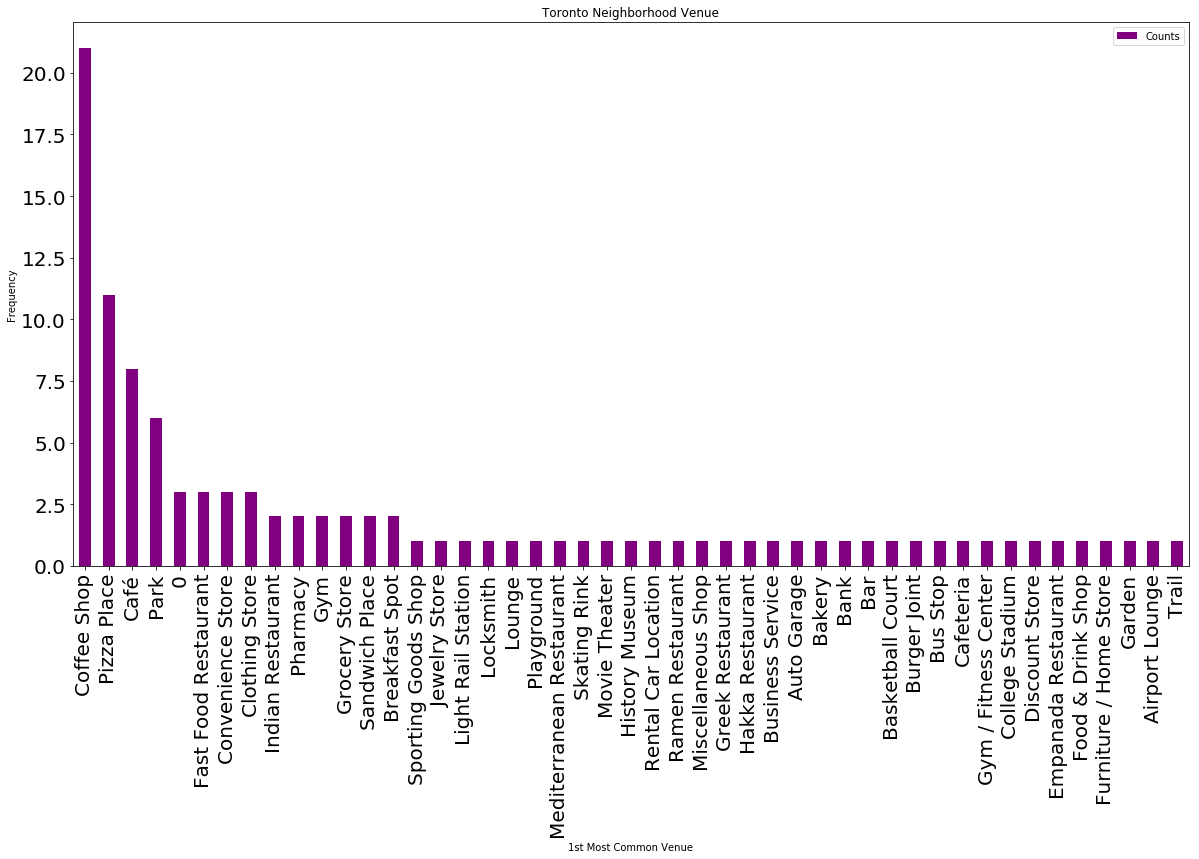

In [81]:
#Plotting the most common venues of Toronto on a bar chart
toronto_sorted.plot(kind='bar',figsize = (20,10), fontsize = 20, color='purple')
plt.ylabel('Frequency')
plt.title('Toronto Neighborhood Venue')
plt.show()

In [82]:
#Getting the neighborhoods for the top 4 most common venues
list_top_venues = ['Coffee Shop','Pizza Place','Café', 'Park']
print('-------------------------------------------------------')
for venue in list_top_venues:
    print('The nearest neighborhood to the ' + venue + ' is : ')
    locator = toronto_new_df.loc[toronto_new_df['1st Most Common Venue'] == venue]
    print(locator['Neighborhood'].values)
    print('---------------------------------------------------')

-------------------------------------------------------
The nearest neighborhood to the Coffee Shop is : 
['Woburn' 'Bathurst Manor, Downsview North, Wilson Heights' 'The Beaches'
 'North Toronto West'
 'Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West'
 'Cabbagetown, St. James Town' 'Church and Wellesley'
 'Harbourfront, Regent Park' 'St. James Town' 'Berczy Park'
 'Central Bay Street' 'Adelaide, King, Richmond'
 'Harbourfront East, Toronto Islands, Union Station'
 'Design Exchange, Toronto Dominion Centre'
 'Commerce Court, Victoria Hotel' 'Bedford Park, Lawrence Manor East'
 'The Annex, North Midtown, Yorkville' 'Stn A PO Boxes 25 The Esplanade'
 'First Canadian Place, Underground city' "Queen's Park"
 'Canada Post Gateway Processing Centre']
---------------------------------------------------
The nearest neighborhood to the Pizza Place is : 
['Guildwood, Morningside, West Hill'
 "Clarks Corners, Sullivan, Tam O'Shanter" 'Willowdale West'
 'Victoria Village' 'Woodbi

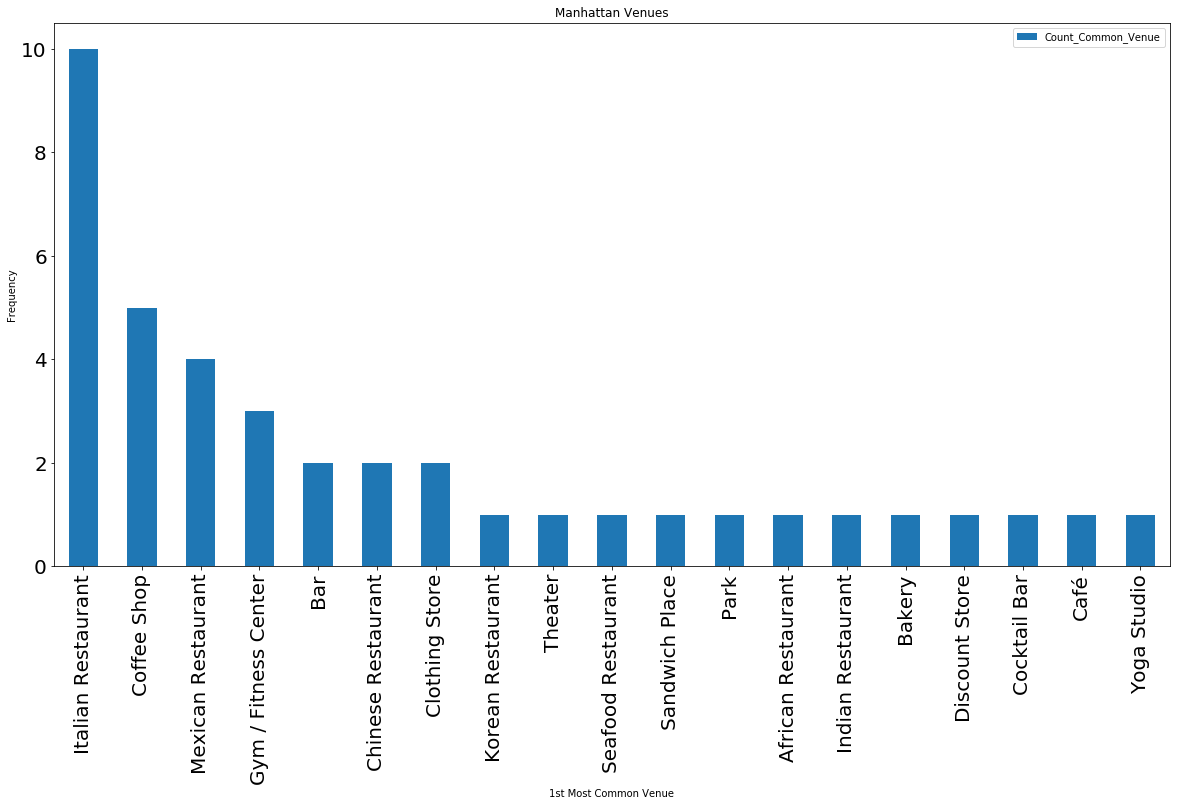

In [83]:
#Plotting the most common venues of Manhattan on a bar chart
manhattan_sorted.plot(kind='bar', figsize = (20,10), fontsize = 20)
plt.ylabel('Frequency')
plt.title('Manhattan Venues')
plt.show()

In [84]:
#Getting the neighborhoods of Manhattan for the top 4 most common venues
list_top_venues = ['Italian Restaurant','Coffee Shop','Mexican Restaurant', 'Gym / Fitness Center']
print('-------------------------------------------------------')
for venue in list_top_venues:
    print('The nearest neighborhood to the ' + venue + ' is : ')
    locator = manhattan_new.loc[manhattan_new['1st Most Common Venue'] == venue]
    print(locator['Neighborhood'].values)
    print('---------------------------------------------------')

-------------------------------------------------------
The nearest neighborhood to the Italian Restaurant is : 
['Upper East Side' 'Yorkville' 'Lenox Hill' 'Upper West Side'
 'Greenwich Village' 'Tribeca' 'West Village' 'Noho' 'Turtle Bay'
 'Hudson Yards']
---------------------------------------------------
The nearest neighborhood to the Coffee Shop is : 
['Murray Hill' 'Chelsea' 'Morningside Heights' 'Financial District'
 'Carnegie Hill']
---------------------------------------------------
The nearest neighborhood to the Mexican Restaurant is : 
['Inwood' 'Hamilton Heights' 'East Harlem' 'Tudor City']
---------------------------------------------------
The nearest neighborhood to the Gym / Fitness Center is : 
['Lincoln Square' 'Civic Center' 'Sutton Place']
---------------------------------------------------
